In [65]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import yaml
import pandas as pd
import scipy.signal as signal
import scipy.stats as stats


In [66]:
mouse = 'TAA0000066'
session = '-t12'
date = '20250129'
base_path = 'D:/ExampleMouse/'

session_path = 'D:/ExampleMouse/TAA0000066/ses-018_date-20250403_protocol-t12/'
imaging_path = 'D:/ExampleMouse/TAA0000066/ses-018_date-20250403_protocol-t12/funcimg/Session/suite2p/plane0'
frame_ix = np.load(os.path.join(session_path, 'valid_frames.npz'))

In [67]:
#load the imaging data
f = np.load(os.path.join(imaging_path, 'F.npy'))
fneu = np.load(os.path.join(imaging_path, 'Fneu.npy'))
spks = np.load(os.path.join(imaging_path, 'spks.npy'))
iscell = np.load(os.path.join(imaging_path, 'iscell.npy'))
ops = np.load(os.path.join(imaging_path, 'ops.npy'), allow_pickle=True).item()
seg = np.load(os.path.join(imaging_path, 'meanImg_seg.npy'), allow_pickle=True).item()

In [68]:
import parse_session_functions
session = parse_session_functions.analyse_npz(mouse,date,plot=False)

Performance =  0.7336947278911565
Number of laps =  109


c:\Users\Sumiya\miniconda3\envs\suite2p2\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Sumiya\miniconda3\envs\suite2p2\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Sumiya\Workstation2025\VR_ABCD\notebook\parse_session_functions.py:384: RuntimeWarning: Mean of empty slice
  av_speed_per_bin = np.nanmean(speed_per_bin, axis=0)
c:\Users\Sumiya\miniconda3\envs\suite2p2\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Sumiya\Workstation2025\VR_ABCD\notebook\parse_session_functions.py:405: RuntimeWarning: Mean of empty slice
  state1_speed = np.nanmean(state1_laps, axis=0)
c:\Users\Sumiya\Workstation2025\VR_ABCD\notebook\parse_session_functions.py:407: RuntimeWarning:

In [69]:
# calculate df/f
iscell = iscell.astype(bool)
cells_f = f[iscell[:,0],:]
cells_fneu = fneu[iscell[:,0],:]
cells_spks = spks[iscell[:,0],:]

cells_f = cells_f[:,frame_ix['valid_frames']]
cells_fneu = cells_fneu[:,frame_ix['valid_frames']]
cells_spks = cells_spks[:,frame_ix['valid_frames']]

cells_f_corr = (cells_f - cells_fneu*0.7)
f0 = np.percentile(cells_f, 25, axis=1)
cells_df = ((cells_f_corr.T - f0)/f0).T

In [70]:
#create reward_psth for all cells
window = np.arange(-22, 22)
reward_idx = session['rewards']
all_cells_avg = np.zeros((cells_df.shape[0], len(window)))
for c in range(cells_df.shape[0]):
    cell_rewards = np.zeros((len(window), len(reward_idx)))
    for i in range(len(reward_idx)):
        reward = reward_idx[i]
        # print(reward)
        if reward+window[-1] < len(cells_df[c,:]):
            cell_rewards[:,i] = cells_df[c, reward+window]
        else:
            cell_rewards[:,i] = cells_df[c, reward:len(cells_df[c,:])]
    cell_rewards_avg = np.mean(cell_rewards, axis=1)
    cell_rewards_std = np.std(cell_rewards, axis=1)
    cell_rewards_sem = cell_rewards_std/np.sqrt(len(reward_idx))
    all_cells_avg[c,:] = cell_rewards_avg

all_cells_avg = stats.zscore(all_cells_avg, axis=1)


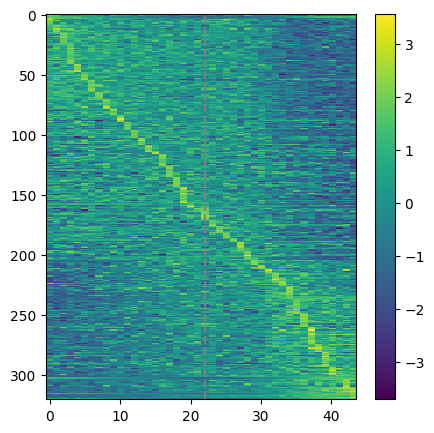

In [71]:
sortidx = np.argsort(np.argmax(all_cells_avg, axis=1))
# sortidx = np.arange(0,all_cells_avg.shape[0]) #to switch off sorting
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(all_cells_avg[sortidx,:], aspect='auto', interpolation='none')
cbar = plt.colorbar(ax.imshow(all_cells_avg[sortidx,:], aspect='auto', interpolation='none'), ax=ax)
#draw a vertical line at reward time
ax.axvline(x=22, color='gray', linestyle='--')

In [18]:
session['rewards'][40] # 31670

32674

In [ ]:
32674 is A

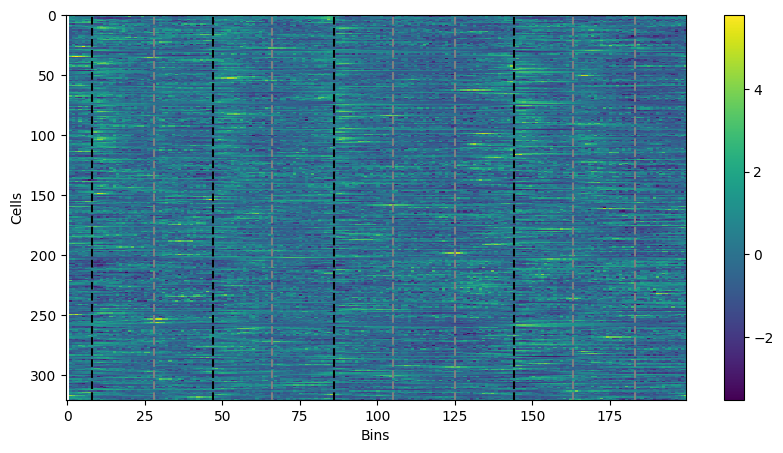

In [10]:
sortidx = np.argsort(np.argmax(all_cells_position_fr, axis=1))
# sortidx = np.arange(0,all_cells_position_fr.shape[0]) #to switch off sorting
all_cells_position_fr = stats.zscore(all_cells_position_fr, axis=1,nan_policy='omit')
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow(all_cells_position_fr[sortidx,:], aspect='auto', interpolation='none')
ax.set_xlabel('Bins')
ax.set_ylabel('Cells')
cbar = plt.colorbar(ax.imshow(all_cells_position_fr[sortidx,:], aspect='auto', interpolation='none'), ax=ax)
#add the goals as vertical lines
goals = session['goals']
goals = np.digitize(goals, bin_edges)
landmarks = session['landmarks']
landmarks = np.digitize(landmarks, bin_edges)
for i in range(len(landmarks)):
    ax.axvline(x=landmarks[i][0], color='gray', linestyle='--')
for i in range(len(goals)):
    ax.axvline(x=goals[i][0], color='black', linestyle='--')


In [11]:
#find indices when a landmark was entered
landmark_idx = []
for i in range(session['num_laps']-1):
    lap_idx = np.where(session['lap_idx'] == i)[0]
    for j in range(len(session['landmarks'])):
        landmark = session['landmarks'][j][0]
        lm_entry = np.where(session['position'][lap_idx] > landmark)[0]
        lm_entry = lm_entry[3:] # to account for end of previous lap mislabeled frames (need to fix in future)
        landmark_idx.append(lap_idx[lm_entry[0]])
landmark_idx = np.array(landmark_idx)


In [28]:
#get identity of the entered landmark
unique_lm_vec = np.arange(0,len(session['landmarks']))
unique_lm_ids = []
#concatenate that vector n times (n = number of laps)
for i in range(session['num_laps']-1):
    #add the lap number to the unique_lm_ids
    unique_lm_ids = np.concatenate([unique_lm_ids, unique_lm_vec])


In [30]:
len(unique_lm_ids)

1080

In [72]:
def save_dF_traces_npy(array: np.ndarray, save_path: str):
    """
    Save a 2D NumPy array (neurons x time) in a format compatible with the
    `load_neurons_x_time` function, packed as a dictionary in a 0-dim array.
    
    Args:
        array (np.ndarray): A 2D NumPy array with shape (neurons, timepoints)
        save_path (str): Path to save the .npy file (should end with .npy)
    """
    if not isinstance(array, np.ndarray) or array.ndim != 2:
        raise ValueError("Input must be a 2D NumPy array (neurons x time).")
    
    if not save_path.endswith('.npy'):
        raise ValueError("save_path must end with '.npy'")

    data_dict = {'dF_traces': array}
    # Save as 0-dim object array (MATLAB-style)
    np.save(save_path, np.array(data_dict, dtype=object))
    print(f"dF_traces saved to {save_path} with shape {array.shape}")

In [73]:
save_dF_traces_npy(cells_df, './test.npy')

dF_traces saved to ./test.npy with shape (321, 121277)


In [ ]:
spikerate_df = np.load('./test_cascade.npy')

In [75]:
cells_df.shape

(321, 122000)

In [ ]:
# cells_f = cells_f[:,frame_ix['valid_frames']]
# cells_fneu = cells_fneu[:,frame_ix['valid_frames']]
# cells_f_corr = (cells_f - cells_fneu*0.7)
# f0 = np.percentile(cells_f, 25, axis=1)
# cells_df = ((cells_f_corr.T - f0)/f0).T

In [53]:
session['active_goal']

array([[0., 7., 7., ..., 7., 4., 4.],
       [4., 4., 4., ..., 2., 2., 2.],
       [2., 2., 2., ..., 0., 0., 0.],
       ...,
       [2., 0., 0., ..., 0., 7., 7.],
       [7., 7., 7., ..., 4., 4., 4.],
       [4., 4., 4., ..., 2., 2., 2.]])

In [75]:
# easiest approximation to phase is to bin frames between rewards into 90 bins
# and excluded last trial (maybe not needed)
# get frames between rewards
reward_ix = session['rewards'][:-4]
bins = 90
goal_rew_vec = np.arange(4)

goal_rew_vec = np.tile(goal_rew_vec, len(reward_ix)//4)
neural_data = np.zeros((len(reward_ix)//4, cells_df.shape[0], bins*4)) # trials, neurons, time_bins

In [76]:
for cell in range(cells_df.shape[0]):
    binned_phase_firing = np.zeros((len(reward_ix), bins))
    for reward in range(len(reward_ix)-1):
        phase_frames = np.arange(reward_ix[reward], reward_ix[reward+1])
        bin_edges = np.linspace(reward_ix[reward], reward_ix[reward+1], bins+1)
        phase_firing = cells_df[cell,phase_frames]
        bin_ix = np.digitize(phase_frames, bin_edges)
        for deg in range(bins):
            binned_phase_firing[reward,deg] = np.mean(phase_firing[bin_ix == deg])
    binned_B = binned_phase_firing[np.where(goal_rew_vec==0)[0],:]
    binned_C = binned_phase_firing[np.where(goal_rew_vec==1)[0],:]
    binned_D = binned_phase_firing[np.where(goal_rew_vec==2)[0],:]
    binned_A = binned_phase_firing[np.where(goal_rew_vec==3)[0],:]
    # min_state = np.min([binned_A.shape[0],binned_B.shape[0],binned_C.shape[0],binned_D.shape[0]], axis=0)
    binned_all = np.concatenate((binned_A, binned_B, binned_C, binned_D), axis=1)
    neural_data[:,cell,:] = binned_all


In [77]:
np.save('./neural_data.npy', neural_data)

In [58]:
reward_ix = session['rewards']
bins = 90
binned_phase_firing = np.zeros((len(reward_ix)-1, bins))
goal_rew_vec = np.arange(4)
goal_rew_vec = np.tile(goal_rew_vec, len(session['rewards'])//4)
goal_rew_vec = goal_rew_vec[:-1]
avg_bin = np.zeros((cells_df.shape[0], bins*4))

for c in range(cells_df.shape[0]):
    for i in range(len(reward_ix)-1):
        phase_frames = np.arange(reward_ix[i], reward_ix[i+1])
        # print(len(phase_frames))
        bin_edges = np.linspace(reward_ix[i], reward_ix[i+1], bins+1)
        # print(bin_edges)
        phase_firing = cells_df[c,phase_frames]
        bin_ix = np.digitize(phase_frames, bin_edges)
        for j in range(bins):
            binned_phase_firing[i,j] = np.mean(phase_firing[bin_ix == j])
    binned_B = binned_phase_firing[np.where(goal_rew_vec==0)[0],:]
    binned_C = binned_phase_firing[np.where(goal_rew_vec==1)[0],:]
    binned_D = binned_phase_firing[np.where(goal_rew_vec==2)[0],:]
    binned_A = binned_phase_firing[np.where(goal_rew_vec==3)[0],:]
    min_state = np.min([binned_A.shape[0],binned_B.shape[0],binned_C.shape[0],binned_D.shape[0]], axis=0)
    binned_all = np.concatenate((binned_A[:min_state,:], binned_B[:min_state,:], binned_C[:min_state,:], binned_D[:min_state,:]), axis=1)
    avg_bin[c,:] = np.mean(binned_all, axis=0)

In [ ]:
def save_dF_traces_npy(array: np.ndarray, save_path: str):
    """
    Save a 2D NumPy array (neurons x time) in a format compatible with the
    `load_neurons_x_time` function, packed as a dictionary in a 0-dim array.
    
    Args:
        array (np.ndarray): A 2D NumPy array with shape (neurons, timepoints)
        save_path (str): Path to save the .npy file (should end with .npy)
    """
    if not isinstance(array, np.ndarray) or array.ndim != 2:
        raise ValueError("Input must be a 2D NumPy array (neurons x time).")
    
    if not save_path.endswith('.npy'):
        raise ValueError("save_path must end with '.npy'")

    data_dict = {'dF_traces': array}
    # Save as 0-dim object array (MATLAB-style)
    np.save(save_path, np.array(data_dict, dtype=object))
    print(f"dF_traces saved to {save_path} with shape {array.shape}")

IndexError: index 344 is out of bounds for axis 0 with size 321

In [ ]:
save_dF_traces_npy()

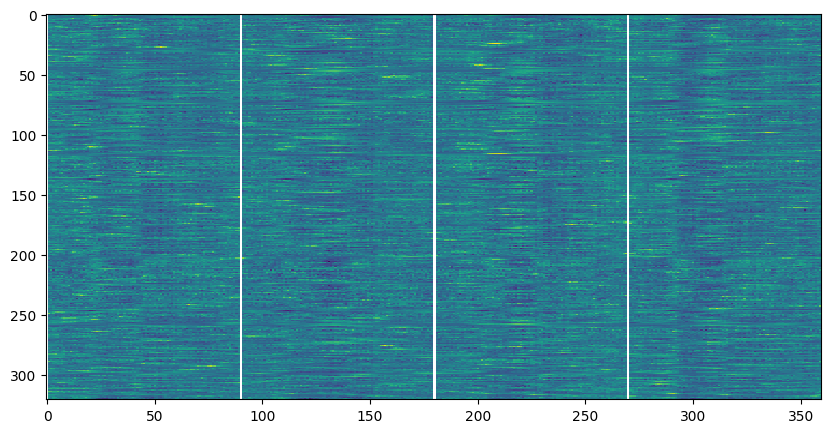

In [44]:
avg_bin_zscore = stats.zscore(avg_bin, axis=1,nan_policy='omit')
sortidx = np.argsort(np.argmax(avg_bin_zscore[:,90:180], axis=1))
# print(sortidx)  
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow(avg_bin_zscore[sortidx,:], aspect='auto', interpolation='none')

In [ ]:
avg_bin_zscore.shape``

(321, 360)

In [63]:
avg_bin_zscore = stats.zscore(avg_bin, axis=1,nan_policy='omit')

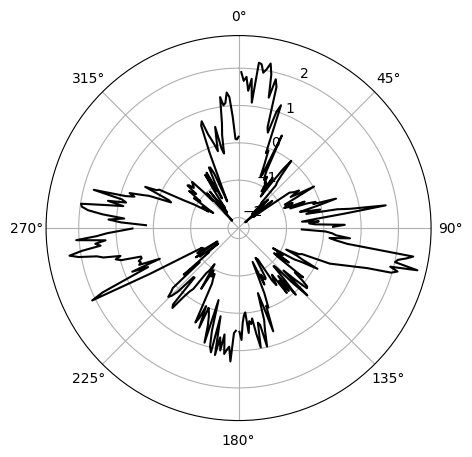

In [60]:
#plot one line (single cell) of the above as a polar plot
fig, ax = plt.subplots(1,1, figsize=(10,5), subplot_kw=dict(polar=True))
ax.plot(np.linspace(0, 2*np.pi, bins*4), avg_bin_zscore[sortidx[120],:], color='black')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)


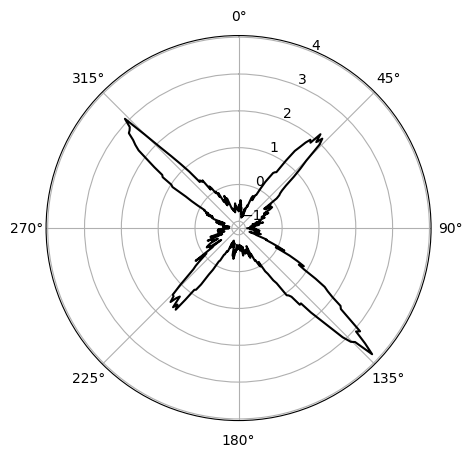

In [59]:
#plot one line (single cell) of the above as a polar plot
fig, ax = plt.subplots(1,1, figsize=(10,5), subplot_kw=dict(polar=True))
ax.plot(np.linspace(0, 2*np.pi, bins*4), avg_bin_zscore[198,:], color='black')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

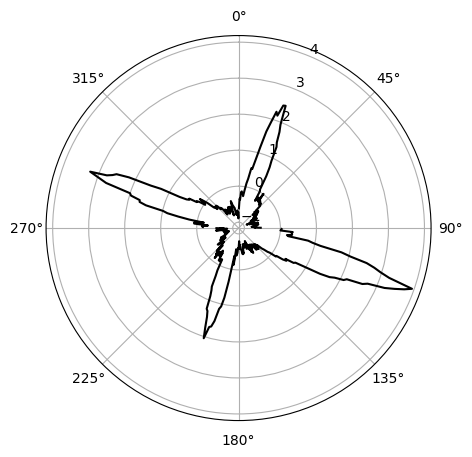

In [64]:
#plot one line (single cell) of the above as a polar plot
fig, ax = plt.subplots(1,1, figsize=(10,5), subplot_kw=dict(polar=True))
ax.plot(np.linspace(0, 2*np.pi, bins*4), avg_bin_zscore[198,:], color='black')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
